In [1]:
mp_pdf = False
import django, sys, os
if mp_pdf:
    import matplotlib
    matplotlib.use('pgf')
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "xelatex",
        "figure.figsize": [12,7]
    }
    matplotlib.rcParams.update(pgf_with_latex)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle
%matplotlib notebook

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from scipy.sparse import coo_matrix, find
from sklearn.manifold import TSNE

from scoping.models import *
from tmv_app.models import *
import tmv_app.utils.plotting as tplots
from time import time
from matplotlib import patches

run_id = 1013
s = 0
#s = 50000
p = 50

run_id=665
run_id=1056
run_id=1103
run_id = 1275
p = 100
#p = 50

stat = RunStats.objects.get(run_id=run_id)
q = stat.query
qid = q.id


In [2]:
def square_distance(x,y): return sum([(xi-yi)**2 for xi, yi in zip(x,y)]) 

In [15]:
class SquareCollection:
    def __init__(self):
        self.objects = []
        
    def add(self, o):
        self.objects.append(o)

    def get(self,**kwargs):
        matches = []
        for o in self.objects:
            match = True
            for k,v in kwargs.items():
                if getattr(o,k)!=v:
                    match=False
            if match:
                matches.append(o)
        if len(matches) > 0:
            return matches[0]
        else:
            return None
                
class CoordSquare:
    def __init__(self,x1,x2,y1,y2,r_ind,tsne_results,ar=None):
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.r_ind = r_ind
        self.tsne_results = tsne_results
        self.ar = ar
        self.size = self.r_ind.shape[0]
        self.share = None
        self.av_y = None
        self.H = None
    
    def get_points(self):
        r = self.tsne_results#[self.r_ind[:,0],:]
        conditions = (r[:,0]>self.x1) & (r[:,0]<self.x2) & (r[:,1]>self.y1) & (r[:,1]<self.y2)
        self.r = r[conditions]
        self.r_ind = self.r_ind[conditions]
        
        self.share = self.r.shape[0] / self.size
        
        return self.r.shape[0] / self.size
    def summarise_topics(self,run_id):
        stat = RunStats.objects.get(pk=run_id)
        docs = Doc.objects.filter(id__in=self.r_ind)
        if stat.method=="DT":
            dt_string = 'docdynamictopic'
            DTO = DocDynamicTopic.objects
        else:
            dt_string = 'doctopic'
            DTO = DocTopic.objects
        
        if docs.count()<100:
            self.av_y = None
            self.H = None
        else:
            self.av_y = np.mean(list(docs.values_list('PY',flat=True)))
            H = 0
            ts = DTO.filter(
                run_id=run_id,
                score__gt=stat.dt_threshold,
                doc__id__in=self.r_ind
            ).values('topic').annotate(
                pzc = Sum('score')
            )
            for t in ts:
                H+=t['pzc']*np.log(t['pzc'])
            self.H = -1*H
            
        topics = docs.filter(
            **{f'{dt_string}__run_id': run_id}
        ).values(f'{dt_string}__topic__title').annotate(
            tscore=Sum(f'{dt_string}__score')
        ).order_by('-tscore')
        total = topics.aggregate(tsum = Sum('tscore'))
        df = pd.DataFrame.from_dict(list(topics))
        df['x1'] = self.x1
        df['x2'] = self.x2
        df['y1'] = self.y1
        df['y2'] = self.y2
        df['proportion'] = df['tscore'] / total['tsum']
        df = df[df['proportion']>0.001]
        return df

In [4]:
m = np.load('../tsne_results/data/run_{}_s_{}_m.npy'.format(run_id,s))
r_ind = np.load('../tsne_results/data/run_{}_s_{}_r_ind.npy'.format(run_id,s))
tsne_results = np.load('../tsne_results/data/run_{}_s_{}_p{}.npy'.format(run_id,s,p))

In [10]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
no_oecd_ids = r_ind

oecd_cats = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    {'wc__oecd': None}
]

oecd_df = pd.DataFrame()
for i,c in enumerate(oecd_cats):
    ds = Doc.objects.filter(query=q,wc__oecd=c['wc__oecd']).values_list('id', flat=True)
    c['docs'] = list(set(ds) & set(r_ind))
    oecd_df = pd.concat([oecd_df,pd.DataFrame({
        "oecd": c['wc__oecd'], "doc": c['docs']
    })])
    c['n_docs'] = len(c['docs'])
    c['name'] = c['wc__oecd']
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_oecd_ids = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]
    
from operator import itemgetter
oecd_cats = sorted(oecd_cats, key=itemgetter('n_docs'), reverse=True)

In [ ]:
oecd_df = oecd_df.reset_index(drop=True)
oecd_df.to_csv(f"../tables/oecd_cats_{qid}.csv")

calculating points took 1.647s.
[-20. -15. -10.  -5.   0.   5.  10.  15.  20.]


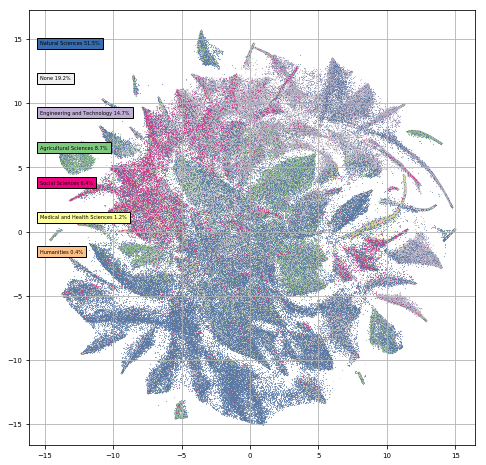

In [19]:
import importlib
importlib.reload(tmv_app.utils.plotting)

plt.close()

fig, ax = plt.subplots( figsize=(8,8))
tplots.plot_tsne(r_ind,tsne_results,oecd_cats,no_oecd_ids,verbose=True,ax=ax)
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_oecds.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_oecds.png'.format(run_id,s,p))

sc = SquareCollection()   
xs = plt.xticks()[0]
ys = plt.yticks()[0]

print(xs)

for i, x1 in enumerate(xs):
    if i==len(xs)-1:
        break
    x2 = xs[i+1]
    for j, y1 in enumerate(ys):
        if j==len(ys)-1:
            break
        y2 = ys[j+1]

        cs = CoordSquare(x1,x2,y1,y2,r_ind,tsne_results,0)
        cs.get_points()
        sc.add(cs)
    
plt.show()

In [20]:
df = None
for cs in sc.objects:
    if cs.share > 0:
        topics = cs.summarise_topics(run_id)
        if df is None:
            df = topics
        else:
            df = df.append(topics)
df.to_csv(f"../tables/tsne_topic_index_{run_id}_{p}.csv")

calculating points took 1.425s.


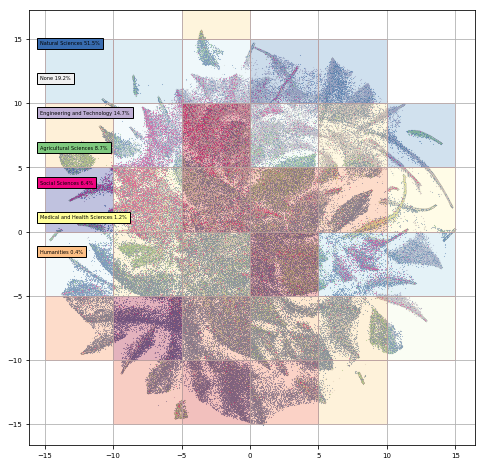

In [22]:
import importlib
importlib.reload(tmv_app.utils.plotting)

fig, ax = plt.subplots( figsize=(8,8))

tplots.plot_tsne(
    r_ind,tsne_results,oecd_cats,no_oecd_ids,
    verbose=True,ax=ax,
    heat_var="av_y",sc=sc,cmapname="RdYlBu"
)

if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_timeheat.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_timeheat.png'.format(run_id,s,p))
    
plt.show()

calculating points took 1.754s.


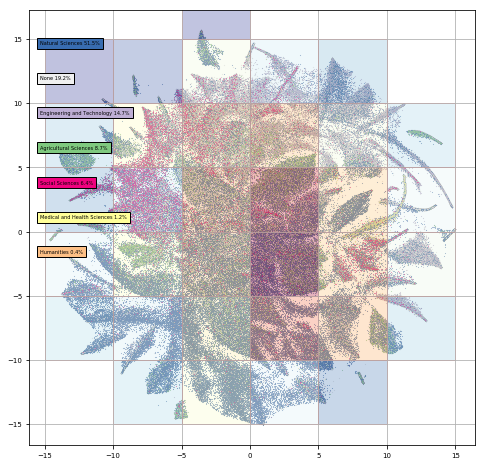

In [23]:
import importlib
importlib.reload(tmv_app.utils.plotting)

fig, ax = plt.subplots( figsize=(8,8))

tplots.plot_tsne(
    r_ind,tsne_results,oecd_cats,no_oecd_ids,
    verbose=True,ax=ax,
    heat_var="H",sc=sc,cmapname="RdYlBu"
)

if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_H_heat.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_H_heat.png'.format(run_id,s,p))
    
plt.show()

In [6]:
dts = DocDynamicTopic.objects.filter(
    run_id=run_id, score__gt=0.03
).values('doc').annotate(
    n = Count('pk')
)
thickness_cats = []
m = dts.order_by('-n').first()['n']
m = 10
thicknesses = list(range(m+1))

from matplotlib import cm

cmap = cm.get_cmap("YlGnBu")

for t in thicknesses:
    if t==0:
        doc_ids = list(set(r_ind) - set(dts.values_list('doc__id',flat=True)))
    else:
        doc_ids = list(dts.filter(n=t).values_list('doc__id',flat=True))
    thickness_cats.append({
        "name": str(t),
        "docs": doc_ids,
        "n_docs": len(doc_ids),
        "color": cmap(t/m),
        "dis": np.argwhere(np.isin(r_ind,doc_ids))
    })
    
    


calculating points took 1.616s.


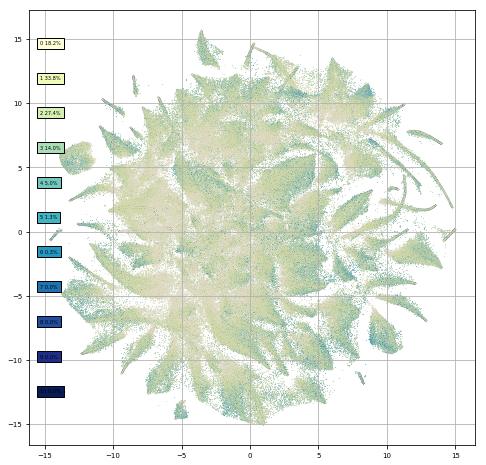

In [7]:
fig, ax = plt.subplots( figsize=(8,8))
tplots.plot_tsne(r_ind,tsne_results,thickness_cats,[],verbose=True,ax=ax)
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_thickness.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_thickness.png'.format(run_id,s,p))
    
plt.show()


In [8]:

ars = AR.objects.filter(ar__gt=0).order_by('ar')
m = ars.count()

ar_cats = []

for i,ar in enumerate(ars):
    ys = range(ar.start,ar.end+1)
    ydocs = Doc.objects.filter(query=q,PY__in=ys).values_list('pk',flat=True)  
    ar_cats.append({
        "name": ar.name,
        "docs": list(set(ydocs) & set(r_ind)),
        "n_docs": len(ydocs),
        "color": cmap(1-(i+1)/m),
        "dis": np.argwhere(np.isin(r_ind,ydocs))
    })


calculating points took 1.327s.


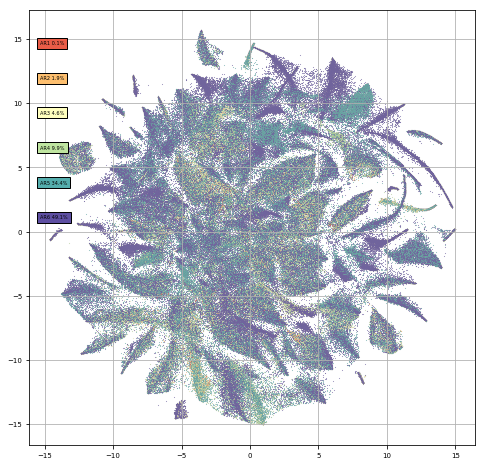

In [9]:
cmap = cm.get_cmap("RdYlBu")

cmaps = [
    #"RdYlBu",
    "Spectral"
]

fig, axs = plt.subplots(len(cmaps), figsize=(8,8*len(cmaps))) 

if len(cmaps)==1:
    axs = [axs]

for a,c in enumerate(cmaps):
    cmap = cm.get_cmap(c)
    ax = axs[a]

    for i, ar in enumerate(ar_cats):
        ar["color"] = cmap(1-(i+1)/m)
        ar["color"] = cmap((i+1)/m)

    tplots.plot_tsne(r_ind,tsne_results,ar_cats,[],verbose=True,ax=ax)
    
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_ars.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_ars.png'.format(run_id,s,p))

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
tplots.plot_tsne(r_ind,tsne_results,ar_cats[:4],[],verbose=True,ax=ax[0])
tplots.plot_tsne(r_ind,tsne_results,ar_cats[4:],[],verbose=True,ax=ax[1])
plt.show()

In [ ]:
colors=["#66c2a5","#fc8d62","#8da0cb"]

no_wg_ids = r_ind
wgs = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
for i,c in enumerate(wgs):
    docs = Doc.objects.filter(
        query=q,ipccref__wg__wg=c['wg']
    ).values_list('id',flat=True)
    c['docs'] = list(set(docs) & set(r_ind))
    c['color'] = colors[i]
    c['name'] = "WG{}".format(c['wg'])
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_wg_ids = no_wg_ids[np.isin(no_wg_ids,c['docs'],invert=True)]
    


In [ ]:
import importlib
importlib.reload(tmv_app.utils.plotting)

fig, ax = plt.subplots(figsize=(8,8))

tmv_app.utils.plotting.plot_tsne(r_ind,tsne_results,wgs,no_wg_ids,verbose=True,ax=ax)

if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_wgs.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_wgs.png'.format(run_id,s,p))


plt.show()

## Plots with certain labelled topics

In [ ]:
import importlib
importlib.reload(tmv_app.utils.plotting)

tops = DynamicTopic.objects.filter(id__in=[
    12156,
    #12179,
    12160, # waste
    12167,
    12187,
    12152,
    12195,
    12150,
    12200,
    12186,
    12157,
    12172,
    12178,
    #12221,
    12202,
    12218
])
tops

fig, ax = plt.subplots( figsize=(8,8)) 
tplots.plot_tsne(
    r_ind,tsne_results,
    wgs,no_wg_ids,verbose=True,ax=ax,
    topics=tops
)

if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_interesting_topics_wgs.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_interesting_topics_wgs.png'.format(run_id,s,p))

In [ ]:
fig, ax = plt.subplots( figsize=(16,16)) 
tplots.plot_tsne(
    r_ind,tsne_results,
    oecd_cats,no_oecd_ids,verbose=True,ax=ax,
    topics=tops
)

if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_interesting_topics_oecds.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_interesting_topics_oecds.png'.format(run_id,s,p))

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(7.2,14.4))
tmv_app.utils.plotting.plot_tsne(
    r_ind,tsne_results,wgs,
    no_wg_ids,axs[0],verbose=True
)

tmv_app.utils.plotting.plot_tsne(
    r_ind,tsne_results,oecd_cats,
    no_oecd_ids,axs[1],verbose=True
)

fig.tight_layout()
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_double.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_double.png'.format(run_id,s,p))

xlim = axs[1].get_xlim()
ylim = axs[1].get_ylim()
        
plt.show()

## Evolution

In [ ]:

import importlib
importlib.reload(tmv_app.utils.plotting)


fig = plt.figure(figsize=(18,12))

sc = SquareCollection()   

rects = False

cat_type = "wgs"

for i,ar in enumerate(AR.objects.filter(ar__gt=0).order_by('ar')):
    ax = fig.add_subplot(2,3,i+1)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ys = range(ar.start,ar.end+1)
    ydocs = Doc.objects.filter(id__in=r_ind,PY__in=ys).values_list('pk',flat=True)  
    
    print(len(ydocs))
    
    doc_matches = np.argwhere(np.isin(r_ind,ydocs))[:,0]
    doc_ids = r_ind[doc_matches]
    results = tsne_results[doc_matches]

    
    if cat_type == "wgs":
        colors=["#66c2a5","#fc8d62","#8da0cb"]
        no_cats = doc_ids
        cats = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
        for i,c in enumerate(cats):
            docs = Doc.objects.filter(
                query=q,PY__in=ys,ipccref__wg__wg=c['wg']
            ).values_list('id',flat=True)
            c['docs'] = list(set(docs) & set(doc_ids))
            c['color'] = colors[i]
            c['name'] = "WG{}".format(c['wg'])
            c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
            no_cats = no_wg_ids[np.isin(no_wg_ids,c['docs'],invert=True)]
    else:
        colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']

        no_cats = doc_ids
        cats = [
            {'wc__oecd': 'Agricultural Sciences'},
            {'wc__oecd': 'Engineering and Technology'},
            {'wc__oecd': 'Humanities'},
            {'wc__oecd': 'Medical and Health Sciences'},
            {'wc__oecd': 'Natural Sciences'},
            {'wc__oecd': 'Social Sciences'},
            {'wc__oecd': None}
        ]
        for i,c in enumerate(cats):
            ds = Doc.objects.filter(query=q, PY__in=ys, wc__oecd=c['wc__oecd']).values_list('id', flat=True)
            c['docs'] = list(set(ds) & set(doc_ids))
            c['name'] = c['wc__oecd']
            c['color'] = colors[i]
            c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
            no_cats = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]        

    
    tp = stat.periods.get(title=ar.name)
    
    ts = DynamicTopic.objects.filter(
        run_id=run_id,
        timedtopic__period=tp,
        timedtopic__share__gt=0.01
    ).order_by('-timedtopic__pgrowthn')[:10]
    
    print(ts.values('title'))
    
    tmv_app.utils.plotting.plot_tsne(
        doc_ids, results, cats,
        no_cats,ax,verbose=True,
        topics=ts, min_cluster=len(ydocs)*0.001
    )
    ax.set_title(ar.name)
    
    xs = ax.get_xticks()
    ys = ax.get_yticks()
    
    
    if rects:
        for i, x1 in enumerate(xs):
            if i==len(xs)-1:
                break
            x2 = xs[i+1]
            for j, y1 in enumerate(ys):
                if j==len(ys)-1:
                    break
                y2 = ys[j+1]

                cs = CoordSquare(x1,x2,y1,y2,doc_ids,results,ar.ar)
                cs.get_points()
                sc.add(cs)
                prev = sc.get(x1=x1,x2=x2,y1=y1,y2=y2,ar=ar.ar-1)

                if prev is not None:        
                    if cs.share > prev.share:
                        col = "green"
                    elif cs.share == prev.share:
                        col = "None"
                    else:
                        col = "red"

                    if abs(cs.share-prev.share) > 0.01:
                        alpha = 0.2
                    else:
                        alpha = 0.1

                    # Create a Rectangle patch
                    rect = patches.Rectangle(
                        (x1,y1),x2-x1,y2-y1,
                        linewidth=1,edgecolor='r',
                        facecolor=col,alpha=alpha
                    )

                    # Add the patch to the Axes
                    ax.add_patch(rect)
                
            #ax.text(
            #    x2-(x2-x1)/2,y2-(y2-y1)/2,"bla",
            #    ha="center",
            #    va="center"
            #)



fig.tight_layout()
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_evolution.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_evolution.png'.format(run_id,s,p))
plt.show()

## Clusters


In [ ]:
import importlib
importlib.reload(tmv_app.utils.plotting)

highlight_doc = np.argwhere(r_ind==69164)[0]

tmv_app.utils.plotting.plot_tsne(r_ind,tsne_results,wgs,no_wg_ids,verbose=True, hdoc=highlight_doc)

In [ ]:
import networkx as nx
import pickle
import random
import scipy
from scipy.sparse import tril

sample = 2

Cmat = scipy.sparse.load_npz(f'../network/bibCouple_q_{qid}_{sample}.npz')

Cmat.data *= Cmat.data>=3
Cmat.eliminate_zeros()

Cmat

In [ ]:
ltri = tril(Cmat,k=-1)
G = nx.from_scipy_sparse_matrix(ltri)

In [ ]:
#G = nx.read_gpickle("/tmp/bibCouple_q_3769.pickle")
#G = nx.read_graph6(f"/tmp/bibCouple_q_{qid}_{sample}.graph6")
with open(f"../network/docnet_dict_q_{qid}_{sample}.pickle", "rb") as f:
    m_dict = pickle.load(f)
with open(f"../network/docnet_revdict_q_{qid}_{sample}.pickle", "rb") as f:
    rev_m_dict = pickle.load(f)

G.size()

In [ ]:
import importlib
importlib.reload(tmv_app.utils.plotting)

impacts = 11110
research = 11046
tech_ccs = 11026
biochar = 11020
aerosols = 11059

biochar = 11725

top = DynamicTopic.objects.get(pk=biochar)

top = DynamicTopic.objects.filter(run_id=run_id).first()
tdocs = Doc.objects.filter(
    docdynamictopic__topic=top,
    docdynamictopic__score__gt=0.03
).order_by('-docdynamictopic__score').values_list('id',flat=True)

highlight_docs = np.argwhere(np.isin(r_ind,tdocs))

tmv_app.utils.plotting.plot_tsne(
    r_ind,tsne_results,wgs,
    no_wg_ids,verbose=True, hdoc=highlight_docs
)

plt.show()

In [ ]:
import itertools

def get_topic_distance_path(top,tdocs):

    distances = []
    paths = []

    dsample_size = 100
    if len(tdocs) < dsample_size:
        dsample = tdocs
    else:
        dsample = random.sample(list(tdocs),dsample_size)

    for x_did,y_did in itertools.product(dsample, repeat=2):
        if x_did != y_did:
            x_ind = np.argwhere(np.isin(r_ind,x_did))[:,0][0]
            y_ind = np.argwhere(np.isin(r_ind,y_did))[:,0][0]
            x_tsne = tsne_results[x_ind]
            y_tsne = tsne_results[y_ind]
            try:
                x = m_dict[x_did]
                y = m_dict[y_did]
                try:
                    path = len(nx.shortest_path(G,x,y))
                except:
                    continue
                    path = 10
                    #continue
            except:
                continue
                path = 10
            paths.append(path)
            distance = square_distance(x_tsne,y_tsne)
            distances.append(distance)
    return distances, paths
            
def plot_distance_path(distances, paths):

    fig, axs = plt.subplots(2)
    axs[0].scatter([path +random.random()*0.4-0.2 for path in paths], [x - 1 for x in distances], s = 8, c = "grey")
    tdf = pd.DataFrame.from_dict({"distance": distances,"path":paths})
    x = []

    for name, group in tdf.groupby('path'):
        x.append(list(group['distance']))
    axs[1].boxplot(x)
    ax2 = axs[1].twinx()
    ax2.plot([i+1 for i in range(len(x))],[len(i) for i in x])    


distances, paths = get_topic_distance_path(top,tdocs)

plot_distance_path(distances, paths)


In [ ]:
def entropy(tdocs,var):
    sums = tdocs.values(var).annotate(
        pzc = Count('pk')
    )
    H = 0
    for s in sums:
        H+=s['pzc']*np.log(s['pzc'])

    return H, sums
H, sums = entropy(tdocs,"wc__oecd")
sums.order_by('-pzc')

In [ ]:
alltops = True
do_distances = False
topic_dicts = []

if alltops:
    try: 
        os.mkdir(f'../tsne_results/plots/topics/{run_id}')
        os.mkdir(f'../tsne_results/plots/topics/{run_id}/{p}')
    except:
        pass
    for top in DynamicTopic.objects.filter(run_id=run_id):
        tdocs = Doc.objects.filter(
            docdynamictopic__topic=top,
            docdynamictopic__score__gt=0.05
        ).order_by('-docdynamictopic__score').values_list('id',flat=True)

        highlight_docs = np.argwhere(np.isin(r_ind,tdocs))

        tmv_app.utils.plotting.plot_tsne(
            r_ind,tsne_results,wgs,
            no_wg_ids,verbose=True, hdoc=highlight_docs
        )       
        
        if not do_distances:
            plt.title(f'{top.title}')
            plt.savefig(f'../tsne_results/plots/topics/{run_id}/{p}/{top.title}.png')
            plt.clf()
            plt.close('all')
        else:
            distances, paths = get_topic_distance_path(top, tdocs)

            plt.title(f'{top.title} average distance: {np.mean(distances)}\nav. shortest path: {np.mean(paths)}')                
            plt.savefig(f'../tsne_results/plots/topics/{run_id}/{p}/{top.title}.png')
            plt.clf()
            plt.close('all')
            
            plot_distance_path(distances, paths)
            plt.savefig(f'../tsne_results/plots/topics/{run_id}/{p}/{top.title}_distances.png')

            plt.clf()
            plt.close('all')
            
            H, sums = entropy(tdocs, 'wosarticle__so')
            
            print(top.title)
            print(pd.DataFrame.from_dict(list(sums.order_by('-pzc'))).head())
                     
            oecd_H, sums = entropy(tdocs, 'wc__oecd')  
            wc_H, sums = entropy(tdocs, 'wc__text')  
            kw_H, sums = entropy(tdocs, 'kw__text')
            
            print(top.title)
            print(pd.DataFrame.from_dict(list(sums.order_by('-pzc'))).head())
            
            wg_H, sums = entropy(tdocs, 'ipccref__wg__wg')
            

            
            topic_dict = {
                "topic_id": top.id,
                "distance": np.mean(distances),
                "path": np.mean(paths),
                "journal_entropy": H,
                "wc_entropy": wc_H,
                "oecd_entroy": oecd_H,
                "wg_entropy": wg_H,
                "kw_entroy": kw_H
            }
            

            topic_dicts.append(topic_dict)
            
df = pd.DataFrame.from_dict(topic_dicts)

In [ ]:
def label_topic(row):
    t = DynamicTopic.objects.get(pk=row['topic_id'])
    return t.title
df['topic__title'] = df.apply(lambda row: label_topic(row), axis=1)
for c in ["journal_entropy","kw_entroy","oecd_entroy","wc_entropy","wg_entropy"]:
    df[c] = -1*df[c]
df

We propose to measure the breadth of a conference by using what we call topic entropy: the conditional entropy of this conference topic distribution. Entropy measures the average amount of information expressed by each assignment to a random variable. If a conference has higher topic entropy, then it more evenly divides its probability mass across the generated topics. If it has lower, it has a far more narrow focus on just a couple of topics. We therefore measured topic entropy:

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
df.to_csv(f"../tables/topic_info_{run_id}_{p}.csv")
pdf = df.sort_values('wg_entropy',ascending=False).reset_index(drop=True)
pdf[['distance',"journal_entropy","kw_entroy","oecd_entroy","path"]].plot(ax=ax)
ax.set_xticks(pdf.index)
ax.set_xticklabels(pdf['topic__title'],rotation=45,ha="right")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
pdf[["oecd_entroy","wg_entropy"]].plot(ax=ax)
ax.set_xticks(pdf.index)
ax.set_xticklabels(pdf['topic__title'],rotation=45,ha="right")
plt.show()

In [ ]:
xlim = axs[1].get_xlim()
ylim = axs[1].get_ylim()

In [ ]:
for i,ar in enumerate(AR.objects.filter(ar__gt=0).order_by('ar')):  
    tp = stat.periods.get(title=ar.name)
    ts = DynamicTopic.objects.filter(
        run_id=run_id,
        timedtopic__period=tp,
        timedtopic__share__gt=0.01
    ).order_by('-timedtopic__pgrowth')[:8]
    print()
    print(ts.values('title'))

In [ ]:
import importlib
importlib.reload(tmv_app.utils.plotting)

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(2,3,1)
do_wgs = True

ar = AR.objects.get(ar=4)
ys = range(ar.start,ar.end+1)
ydocs = Doc.objects.filter(id__in=r_ind,PY__in=ys).values_list('pk',flat=True)  

print(len(ydocs))

doc_matches = np.argwhere(np.isin(r_ind,ydocs))[:,0]
doc_ids = r_ind[doc_matches]
results = tsne_results[doc_matches]

if do_wgs:
    colors=["#66c2a5","#fc8d62","#8da0cb"]
    no_cats = doc_ids
    cats = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
    for i,c in enumerate(cats):
        docs = Doc.objects.filter(
            query=q,PY__in=ys,ipccref__wg__wg=c['wg']
        ).values_list('id',flat=True)
        c['docs'] = list(set(docs) & set(doc_ids))
        c['color'] = colors[i]
        c['name'] = "WG{}".format(c['wg'])
        c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
        no_cats = no_wg_ids[np.isin(no_wg_ids,c['docs'],invert=True)]
else:
    colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']

    no_cats = doc_ids
    cats = [
        {'wc__oecd': 'Agricultural Sciences'},
        {'wc__oecd': 'Engineering and Technology'},
        {'wc__oecd': 'Humanities'},
        {'wc__oecd': 'Medical and Health Sciences'},
        {'wc__oecd': 'Natural Sciences'},
        {'wc__oecd': 'Social Sciences'},
        {'wc__oecd': None}
    ]
    for i,c in enumerate(cats):
        ds = Doc.objects.filter(query=q, PY__in=ys, wc__oecd=c['wc__oecd']).values_list('id', flat=True)
        c['docs'] = list(set(ds) & set(doc_ids))
        c['name'] = c['wc__oecd']
        c['color'] = colors[i]
        c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
        no_cats = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]



tp = stat.periods.get(title=ar.name)

ts = DynamicTopic.objects.filter(
    run_id=run_id,
    timedtopic__period=tp,
    timedtopic__share__gt=0.01
).order_by('-timedtopic__pgrowthn')[:10]

print(ts.values('title'))

tmv_app.utils.plotting.plot_tsne(
    doc_ids, results, cats,
    no_cats, ax, verbose=True,
    topics=ts, min_cluster=len(ydocs)*0.001
)

plt.show()

In [ ]:
def square_distance(x,y): return sum([(xi-yi)**2 for xi, yi in zip(x,y)]) 

def get_doc():
    for i in range(25):
        x = random.randint(0,len(m_dict))
        x_did = rev_m_dict[x]
        try:
            x_ind = np.argwhere(np.isin(r_ind,x_did))[:,0][0]
            x_doc = Doc.objects.get(pk=x_did)
            tsne = tsne_results[x_ind]
            break
        except:
            pass
    return x, x_did, x_ind, x_doc, tsne

X = []
Y = []

for i in range(1000):  
    x, x_ind, x_did, x_doc, x_tsne = get_doc()       
    y, y_ind, y_did, y_doc, y_tsne = get_doc()

    #print(x_doc.title)
    #print(y_doc.title)

    distance = square_distance(x_tsne,y_tsne)

    try:
        path = len(nx.shortest_path(G,x,y))
        X.append(path)
        Y.append(distance)
    except:
        path = 10
        continue
        

    plt.scatter(path + random.random()*0.1-0.05, distance, s = 8, c = "grey")



plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)))


In [ ]:
fig = plt.figure(figsize=(7.2,5))
fig = plt.figure(figsize=(14,10))
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']
for i in range(6):  
    x, x_ind, x_did, x_doc, x_tsne = get_doc()       
    y, y_ind, y_did, y_doc, y_tsne = get_doc()

    #print(x_doc.title)
    #print(y_doc.title)

    distance = square_distance(x_tsne,y_tsne)

    try:
        path = nx.shortest_path(G,x,y)
    except:
        continue
        
    plt.scatter(x_tsne[0],x_tsne[1], c=colors[i],edgecolor="black")
    plt.text(x_tsne[0],x_tsne[1],x_doc.title)
    
    plt.scatter(y_tsne[0],y_tsne[1], c=colors[i],edgecolor="black")
    plt.text(y_tsne[0],y_tsne[1],y_doc.title)
    
    for j in path:
        j_did = rev_m_dict[j]
        j_ind = np.argwhere(np.isin(r_ind,j_did))[:,0][0]
        j_doc = Doc.objects.get(pk=j_did)
        tsne = tsne_results[x_ind]
        plt.scatter(tsne[0],tsne[1], c=colors[i],edgecolor="black")
        #plt.text(y_tsne[0],y_tsne[1],y_doc.title)

In [ ]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']
for i in range(8):  
    x, x_ind, x_did, x_doc, x_tsne = get_doc()       
    y, y_ind, y_did, y_doc, y_tsne = get_doc()

    #print(x_doc.title)
    #print(y_doc.title)

    distance = square_distance(x_tsne,y_tsne)

    try:
        path = nx.shortest_path(G,x,y)
    except:
        continue
        
    print("\n############")
    print(f"T-sne distance {distance}")
    print(f"{x_doc.title}")
    
    for j in path[1:-1]:
        j_did = rev_m_dict[j]
        try:
            j_ind = np.argwhere(np.isin(r_ind,j_did))[:,0][0]
        except:
            pass
        j_doc = Doc.objects.get(pk=j_did)
        print(f" - via - {j_doc.title}")
        tsne = tsne_results[x_ind]
        #plt.scatter(tsne[0],tsne[1], c=colors[i])
        #plt.text(y_tsne[0],y_tsne[1],y_doc.title)
    print(y_doc.title)

## Report topic composition of each square..... give in SM

##  furthest and closest points



def square_distance(x,y): return sum([(xi-yi)**2 for xi, yi in zip(x,y)])    

square_distance(tsne_results[0],tsne_results[1])
ma = 0
mi = 100
for i in range(len(tsne_results)):
    for j in range(len(tsne_results)):
        if i != j:
            d = square_distance(tsne_results[i],tsne_results[j])
            if d < mi:
                mi = d
                p1mi = i
                p2mi = j
            if d > ma:
                ma = d
                p1ma = i
                p1mi = j
        

from scipy.spatial import cKDTree
from scipy.spatial.distance import pdist, squareform
import timeit

Y = pdist(tsne_results[:10000])

Y.shape

m = squareform(Y)

m.shape

outside_points = tsne_results[(abs(tsne_results[:,0])>10) & (abs(tsne_results[:,1])>10)]

Y = pdist(outside_points)

m = squareform(Y)

m[2167,2168]